In [2]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [3]:
### IMPORTS ###

import os
import pandas as pd
import numpy as np 
import scipy
from matplotlib import pyplot as plt

# differential expression
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

# dimentionality reduction and clustering
from sklearn.decomposition import PCA
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
import umap

import statistics
import math

In [4]:
#DATA FROM: https://www.synapse.org/Synapse:syn2812961

In [197]:
### PRE-PROCESSING ###
df_LGG = pd.read_csv("/Users/virajjansari/Documents/classwork/bio165/unc.edu_LGG_IlluminaHiSeq_RNASeqV2.geneExp.tsv", sep="\t").T
df_GBM = pd.read_csv("/Users/virajjansari/Documents/classwork/bio165/unc.edu_GBM_IlluminaHiSeq_RNASeqV2.geneExp.tsv", sep="\t").T

#set the sample IDs to be the header column
df_GBM.columns= df_GBM.iloc[0]
df_GBM.drop("gene_id", inplace=True)

df_LGG.columns= df_LGG.iloc[0]
df_LGG.drop("gene_id", inplace=True)

#add an additional column to indicate tumor type
df_LGG["tumor"] = "LGG"
df_GBM["tumor"] = "GBM"

#combine dataframes for LGG and GBM into one
df_comb = pd.concat([df_LGG, df_GBM])

#make a list to store tumor IDs, and drop the tumor ID column so the dataframe only contains numeric data.
tumor_ID = df_comb["tumor"].tolist()
df_comb.drop(df_comb.columns[-1], axis=1, inplace=True)

display(df_comb)
display(df_GBM)

#convert tumor ID list into a list of colors for use in later plotting
labels = ['LGG', 'GBM']
lgg_label = True
gbm_label = True
colors = []
for t in tumor_ID:
    if t=="LGG":
        colors.append('red')
    elif t=="GBM":
        colors.append('blue')


gene_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932
TCGA-CS-4938-01B-11R-1896-07,0.0,8.7141,22.7523,268.576,845.815,0.0,182.505,0.4196,0.0,0.0,...,64.1913,523.18,1311.52,0.0,1495.7,1598.91,1171.81,836.165,777.848,0.0
TCGA-CS-4941-01A-01R-1470-07,0.0,36.4493,21.1767,156.687,390.269,0.0,325.052,1.7253,0.0,0.0,...,105.935,467.564,1226.71,0.3451,1751.21,3889.92,1707.73,1015.53,18.9786,0.0
TCGA-CS-4942-01A-01R-1470-07,0.0,11.8131,11.0242,185.138,621.453,0.0,131.142,0.0,0.0,0.0,...,115.225,454.325,1102.42,0.346,1586.16,2214.53,1423.88,706.92,1706.23,0.0
TCGA-CS-4943-01A-01R-1470-07,0.0,8.6116,5.0835,269.836,835.729,0.0,83.475,0.3261,0.0,0.0,...,89.0183,491.068,1288.32,3.2607,1760.15,2131.55,1916.99,689.321,268.033,0.0
TCGA-CS-4944-01A-01R-1470-07,0.0,0.0,30.261,216.341,812.508,0.0,80.696,0.0,0.0,0.0,...,42.3654,323.793,1012.73,0.5044,1225.07,1692.6,729.794,456.941,19.6697,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-76-4927-01A-01R-1850-01,0.0,2.4096,6.4257,43.0201,620.884,0.0,168.675,0.8032,0.0,0.0,...,48.1928,273.092,933.333,0.0,987.952,7469.08,1244.18,541.365,13.6546,0.0
TCGA-76-4928-01B-01R-1850-01,0.0,10.1709,6.4812,42.4584,533.742,0.0,193.251,0.4382,0.0,0.0,...,36.3716,237.073,850.131,0.0,844.435,16936.9,1024.98,512.708,7.8878,0.0
TCGA-76-4929-01A-01R-1850-01,0.0,8.4757,3.2496,62.2278,668.9,0.0,329.983,0.5583,0.0,0.0,...,89.3356,439.978,1222.78,2.7917,1370.74,2922.39,1862.65,632.607,10.6086,0.0
TCGA-76-4931-01A-01R-1850-01,0.0,6.16,7.9576,58.8188,458.353,0.0,849.412,0.4706,0.0,0.0,...,48.9412,346.824,1261.18,0.9412,1141.65,7212.24,1561.41,568.941,5.1765,0.0


gene_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932,tumor
TCGA-02-0047-01A-01R-1849-01,0.0,3.0732,6.7611,54.7036,886.321,0.0,232.951,0.0,0.0,0.0,...,356.495,1108.82,0.6146,1207.17,3867.97,1397.09,603.583,6.7611,0.0,GBM
TCGA-02-0055-01A-01R-1849-01,0.0,0.0,15.6973,31.3945,885.774,0.0,162.018,0.5606,0.0,0.0,...,280.308,607.708,5.0456,924.457,11481.4,606.027,718.15,12.3336,0.0,GBM
TCGA-02-2483-01A-01R-1849-01,0.0,2.9467,13.9398,60.3441,1234.83,0.0,135.092,0.0,0.0,0.0,...,406.121,866.28,44.3272,1208.65,5066.81,832.084,705.435,398.945,0.0,GBM
TCGA-02-2485-01A-01R-1849-01,0.0,15.9952,14.9571,91.8238,470.0,0.0,417.619,1.9048,0.0,0.0,...,274.286,1345.71,0.0,1070.0,5090.95,1139.52,700.476,15.7143,0.0,GBM
TCGA-02-2486-01A-01R-1849-01,0.0,5.561,4.8049,62.5366,546.341,0.0,276.219,0.0,0.0,0.0,...,198.171,652.439,0.0,689.634,7800.0,627.439,527.439,69.5122,0.0,GBM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-76-4927-01A-01R-1850-01,0.0,2.4096,6.4257,43.0201,620.884,0.0,168.675,0.8032,0.0,0.0,...,273.092,933.333,0.0,987.952,7469.08,1244.18,541.365,13.6546,0.0,GBM
TCGA-76-4928-01B-01R-1850-01,0.0,10.1709,6.4812,42.4584,533.742,0.0,193.251,0.4382,0.0,0.0,...,237.073,850.131,0.0,844.435,16936.9,1024.98,512.708,7.8878,0.0,GBM
TCGA-76-4929-01A-01R-1850-01,0.0,8.4757,3.2496,62.2278,668.9,0.0,329.983,0.5583,0.0,0.0,...,439.978,1222.78,2.7917,1370.74,2922.39,1862.65,632.607,10.6086,0.0,GBM
TCGA-76-4931-01A-01R-1850-01,0.0,6.16,7.9576,58.8188,458.353,0.0,849.412,0.4706,0.0,0.0,...,346.824,1261.18,0.9412,1141.65,7212.24,1561.41,568.941,5.1765,0.0,GBM


In [45]:
lgg_bio = pd.read_csv("/Users/virajjansari/Documents/classwork/bio165/nationwidechildrens.org_LGG_bio.followup.tsv", sep="\t")
gbm_bio = pd.read_csv("/Users/virajjansari/Documents/classwork/bio165/nationwidechildrens.org_GBM_bio.followup.tsv", sep="\t")

lgg_vital = pd.DataFrame({'sample':lgg_bio.loc[:,"sample"], 'vital':lgg_bio.loc[:,"vital_status"]})
lgg_vital.set_index('sample', inplace=True)
gbm_vital = pd.DataFrame({'sample':gbm_bio.loc[:,"sample"], 'vital':gbm_bio.loc[:,"vital_status"]})
gbm_vital.set_index('sample', inplace=True)

vital_comb = pd.concat([lgg_vital, df_LGG])

df=pd.concat([df_comb, vital_comb])

#print(lgg_vital.loc["TCGA-CS-4938-01B-11R-1896-07","vital"])

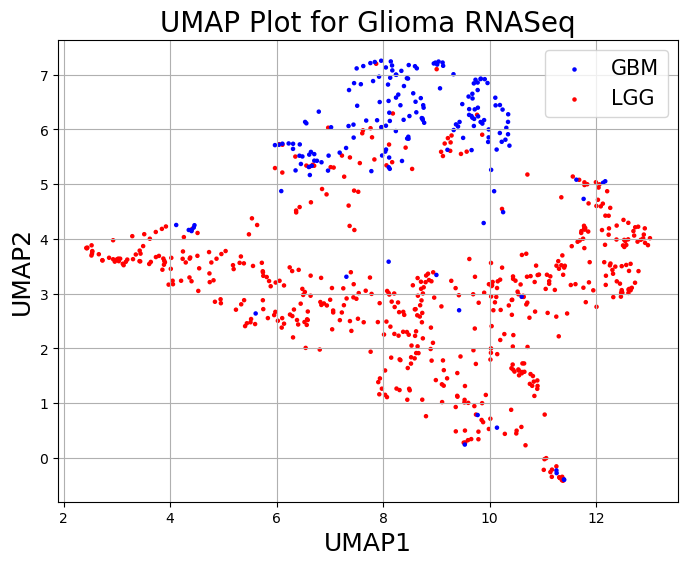

In [211]:
### UMAP PLOT ###

umap_model = umap.UMAP(n_components=2)
umap_components = umap_model.fit_transform(df_comb)

#Create a DataFrame of the UMAP results
umap_df = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2'])

#Plot UMAP results
plt.figure(figsize=(8, 6))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], marker='o', s = 5, c=colors)
plt.scatter(umap_df['UMAP1'][600], umap_df['UMAP2'][600], marker='o', s = 5, c=colors[600], label='GBM')
plt.scatter(umap_df['UMAP1'][0], umap_df['UMAP2'][0], marker='o', s = 5, c=colors[0], label='LGG')

# Add labels and title
plt.xlabel('UMAP1', fontsize=18)
plt.ylabel('UMAP2', fontsize=18)
plt.title('UMAP Plot for Glioma RNASeq', fontsize=20)

# Show the plot
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

            PC1            PC2            PC3           PC4            PC5  \
0  1.215020e+06 -288173.556403 -298514.417188  14600.074157    8943.455111   
1  1.895226e+05   15414.972648  -65398.676780   6472.677735   -7036.069563   
2  2.835434e+05 -121256.351651 -113298.068078    980.715140   -4543.666363   
3 -2.374996e+05  -80381.393691  -59725.788044   -483.411584  -32724.386409   
4  2.529627e+06  665792.261520  850055.727623  86960.896309 -365185.600574   

             PC6            PC7            PC8            PC9          PC10  
0    7892.588940  109221.713607  -17057.135104  -78919.364572  -6288.891299  
1  -88725.846948   54519.518853  -33142.234920  -12873.964185  67751.056009  
2  -21184.916523   13284.174181   10860.106493  -20884.873804  -6384.234243  
3  -25316.997054  -48164.534307   17074.848739   -3716.667412  22521.566952  
4 -359766.419835 -268741.822353  119032.962121  121797.845301 -40931.202925  


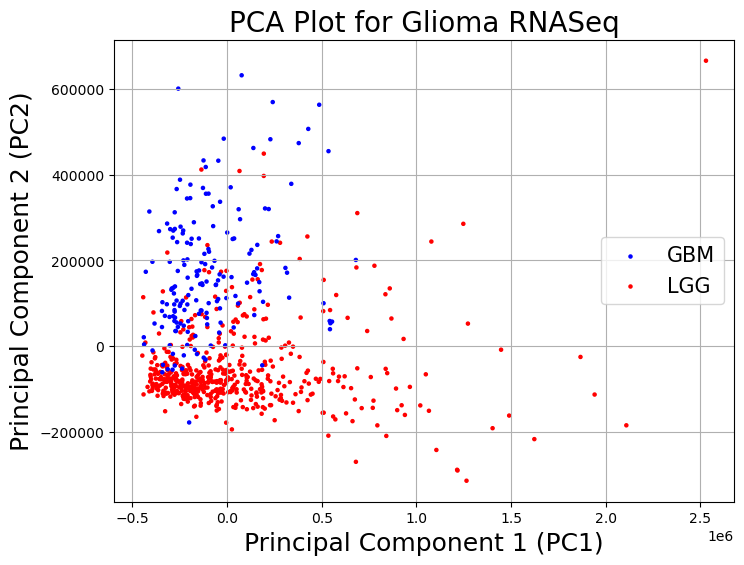

In [231]:
### PCA PLOT ###

# PCA on unscaled RNASeq for all tumor samples
n_PCA_Comps = 10

# Perform PCA
pca = PCA(n_components=n_PCA_Comps)
principal_components = pca.fit_transform(df_comb)

# Create a DataFrame of the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_PCA_Comps)])

# View the first few rows of the PCA results
print(pca_df.head())

# Plot the points in PC1 and PC2
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], marker='o', s=5, c=colors)
plt.scatter(pca_df['PC1'][600], pca_df['PC2'][600], marker='o', s = 5, c=colors[600], label='GBM')
plt.scatter(pca_df['PC1'][0], pca_df['PC2'][0], marker='o', s = 5, c=colors[0], label='LGG')

# Add labels and title
plt.xlabel('Principal Component 1 (PC1)', fontsize=18)
plt.ylabel('Principal Component 2 (PC2)', fontsize=18)
plt.title('PCA Plot for Glioma RNASeq', fontsize=20)
plt.legend(fontsize=15)

plt.grid(True)
plt.show()

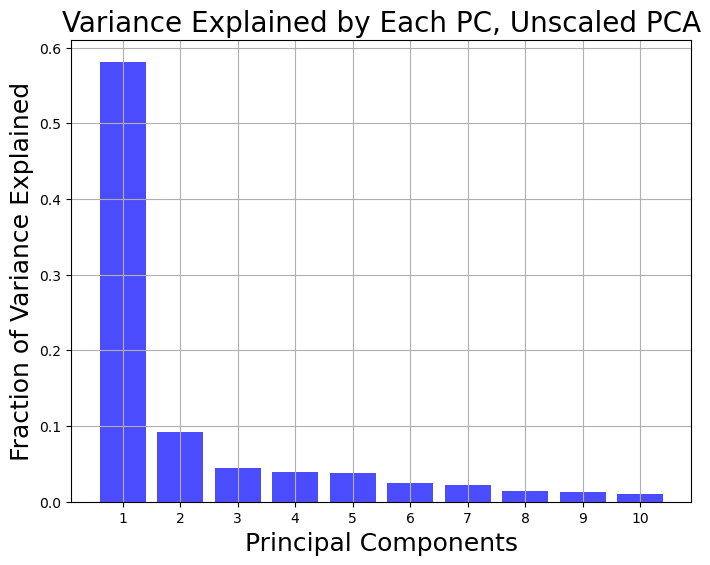

0.878385269680377


In [232]:
### VARIANCE EXPLAINED PCA ###

# Plot the fraction of variance captured by each component
plt.figure(figsize=(8, 6))
plt.bar(range(1, n_PCA_Comps + 1), pca.explained_variance_ratio_, alpha=0.7, color='b')
plt.xlabel('Principal Components', fontsize=18)
plt.ylabel('Fraction of Variance Explained', fontsize=18)
plt.title('Variance Explained by Each PC, Unscaled PCA', fontsize=20)
plt.xticks(range(1, n_PCA_Comps + 1))
plt.grid(True)
plt.show()

print(pca.explained_variance_ratio_.sum())

In [191]:
### LOADINGS OF PRINCIPAL COMPONENTS ###

loadings = pd.DataFrame(pca.components_.T, columns=['PC1','PC2',3,4,5,6,7,8,9,10], index=df_comb.columns)

#Table sorted by loadings for PC1
pc1_loadings = loadings.sort_values(by='PC1')
display(pc1_loadings)

#Table sorted by loadings for PC2
pc2_loadings = loadings.sort_values(by='PC2')
display(pc2_loadings)

,PC1,PC2,3,4,5,6,7,8,9,10
gene_id,,,,,,,,,,
BCAN|63827,-0.016752,-0.155615,-0.006180,-0.017348,-0.155832,0.040626,-0.269406,0.286720,0.086868,0.091559
PTPRZ1|5803,-0.016170,-0.012955,-0.004014,-0.011378,-0.068044,0.012345,0.025596,0.010692,-0.003236,0.288303
TTR|7276,-0.011558,0.018734,-0.011668,0.976424,0.124423,0.085211,-0.047385,0.028250,-0.006002,0.017197
EEF1A1|1915,-0.010877,0.031971,-0.103743,-0.026140,-0.040567,0.117833,-0.259405,-0.015599,-0.083883,0.004575
EEF2|1938,-0.009771,-0.056857,-0.023930,-0.003828,-0.061112,0.027359,-0.095773,0.107334,0.067329,0.015229
...,...,...,...,...,...,...,...,...,...,...
APOE|348,0.032932,-0.052055,0.019449,-0.014980,-0.067191,0.102263,-0.199709,0.126312,0.012841,-0.244955
MBP|4155,0.040200,-0.127691,0.243850,-0.096281,0.703131,0.063360,-0.130952,0.061150,0.103192,0.083002
SPARC|6678,0.093289,-0.054205,0.156963,-0.028712,-0.139038,0.779291,0.091341,-0.301750,0.061065,0.176245


,PC1,PC2,3,4,5,6,7,8,9,10
gene_id,,,,,,,,,,
BCAN|63827,-0.016752,-0.155615,-0.006180,-0.017348,-0.155832,0.040626,-0.269406,0.286720,0.086868,0.091559
GFAP|2670,0.955981,-0.132059,-0.222571,0.016750,0.018206,-0.068312,0.053876,0.012579,-0.033584,0.001400
MBP|4155,0.040200,-0.127691,0.243850,-0.096281,0.703131,0.063360,-0.130952,0.061150,0.103192,0.083002
PLP1|5354,0.022974,-0.109118,0.166840,-0.066226,0.441085,0.062516,-0.080587,0.030018,0.053111,0.082235
SPARCL1|8404,0.031386,-0.086587,0.166791,-0.001551,-0.088286,0.191138,0.073096,-0.030419,-0.085257,-0.223465
...,...,...,...,...,...,...,...,...,...,...
VIM|7431,0.010097,0.177170,-0.126661,-0.022302,0.029861,0.000402,0.027254,-0.047193,0.116166,0.043883
ACTB|60,0.011629,0.187615,-0.132232,-0.025214,0.066924,0.060666,-0.055548,-0.016348,0.087254,0.014680
SPP1|6696,0.001642,0.217670,-0.130059,-0.049176,0.161204,0.129248,-0.005501,-0.040369,-0.176405,-0.037364


# INFO FROM LOADINGS:
Both PC1 and PC2 are most negatively correlated with BCAN

From NIH (https://www.ncbi.nlm.nih.gov/gene/63827): "This gene encodes a member of the lectican family of chondroitin sulfate proteoglycans that is specifically expressed in the central nervous system. This protein is developmentally regulated and may function in the formation of the brain extracellular matrix. This protein is highly expressed in gliomas and may promote the growth and cell motility of brain tumor cells. Alternate splicing results in multiple transcript variants."

PC1 is very strongly correlated with GFAP. 

Per NIH, "This gene encodes one of the major intermediate filament proteins of mature astrocytes. It is used as a marker to distinguish astrocytes from other glial cells during development. Mutations in this gene cause Alexander disease, a rare disorder of astrocytes in the central nervous system. Alternative splicing results in multiple transcript variants encoding distinct isoforms."

PC2 is strongly correlated with CLU.

Per NIH, "The protein encoded by this gene is a secreted chaperone that can under some stress conditions also be found in the cell cytosol. It has been suggested to be involved in several basic biological events such as cell death, tumor progression, and neurodegenerative disorders. Alternate splicing results in both coding and non-coding variants."

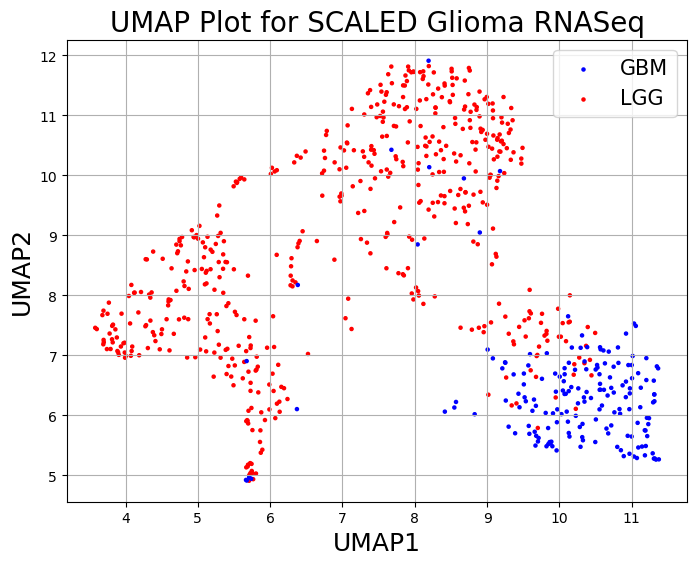

In [215]:
### SCALED UMAP PLOT ###

scaler = StandardScaler()
scaled_df_comb = scaler.fit_transform(df_comb)

umap_model = umap.UMAP(n_components=2)

umap_components = umap_model.fit_transform(scaled_df_comb)

#Create a DataFrame of the UMAP results
umap_df = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2'])

#Plot UMAP results
plt.figure(figsize=(8, 6))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], marker='o', s = 5, c=colors)
plt.scatter(umap_df['UMAP1'][600], umap_df['UMAP2'][600], marker='o', s = 5, c=colors[600], label='GBM')
plt.scatter(umap_df['UMAP1'][0], umap_df['UMAP2'][0], marker='o', s = 5, c=colors[0], label='LGG')


# Add labels and title
plt.xlabel('UMAP1', fontsize=18)
plt.ylabel('UMAP2', fontsize=18)
plt.title('UMAP Plot for SCALED Glioma RNASeq', fontsize=20)

# Show the plot
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

         PC1        PC2        PC3        PC4        PC5        PC6  \
0 -15.839473  -7.045920 -12.095493 -48.295185 -36.918081  15.912150   
1  26.113706   8.221165 -37.456164 -26.702067   7.116287  20.807350   
2 -13.921160  -5.312710 -19.095267 -23.659961 -25.774178 -14.313005   
3 -16.838165 -52.403845 -12.114801  43.574970  -6.192776  -1.322652   
4   4.245431  16.656969  26.045016 -46.310093 -53.042497  -5.364024   

         PC7        PC8        PC9       PC10  
0  -4.366660 -32.366773  28.129591   2.165639  
1  20.587991 -14.516948  16.364863   6.065496  
2  -9.795913 -26.403464  14.849702   9.942398  
3 -26.613123 -32.110534  22.948694  26.988175  
4   5.832853 -30.703445  26.814165   4.674586  


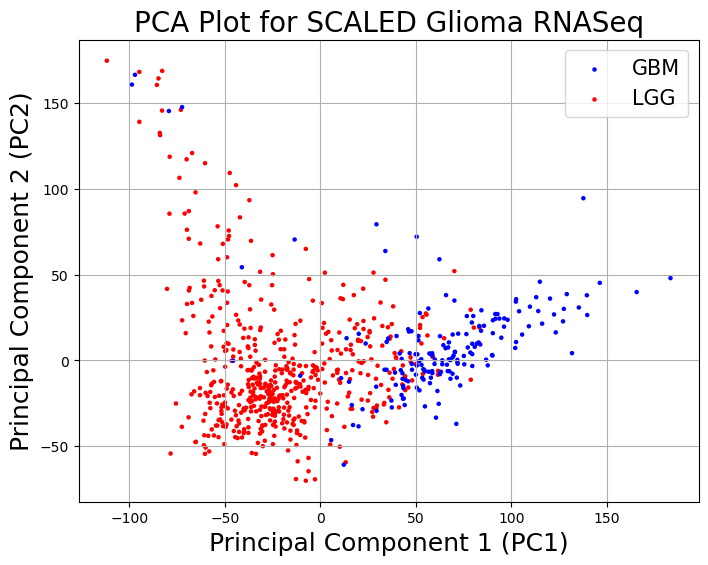

In [235]:
### SCALED PCA PLOT ###

# PCA on scaled RNASeq data for all tumors
n_PCA_Comps = 10  

# Perform PCA
pca = PCA(n_components=n_PCA_Comps)
principal_components = pca.fit_transform(scaled_df_comb)

# Create a DataFrame of the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_PCA_Comps)])

# View the first few rows of the PCA results
print(pca_df.head())

# Plot the points in PC1 and PC2
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], marker='o', s=5, c=colors)
plt.scatter(pca_df['PC1'][600], pca_df['PC2'][600], marker='o', s = 5, c=colors[600], label='GBM')
plt.scatter(pca_df['PC1'][0], pca_df['PC2'][0], marker='o', s = 5, c=colors[0], label='LGG')

# Add labels and title
plt.xlabel('Principal Component 1 (PC1)', fontsize=18)
plt.ylabel('Principal Component 2 (PC2)', fontsize=18)
plt.title('PCA Plot for SCALED Glioma RNASeq', fontsize=20)
plt.legend(fontsize=15)

plt.grid(True)
plt.show()

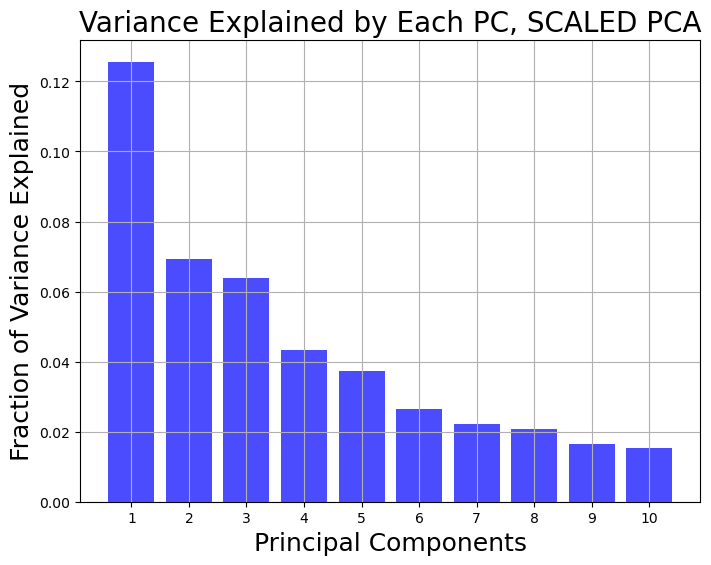

0.4408292571364761


In [237]:
### VARIANCE EXPLAINED FOR SCALED PCA ###

plt.figure(figsize=(8, 6))
plt.bar(range(1, n_PCA_Comps + 1), pca.explained_variance_ratio_, alpha=0.7, color='b')
plt.xlabel('Principal Components', fontsize=18)
plt.ylabel('Fraction of Variance Explained', fontsize=18)
plt.title('Variance Explained by Each PC, SCALED PCA', fontsize=20)
plt.xticks(range(1, n_PCA_Comps + 1))
plt.grid(True)
plt.show()

print(pca.explained_variance_ratio_.sum())

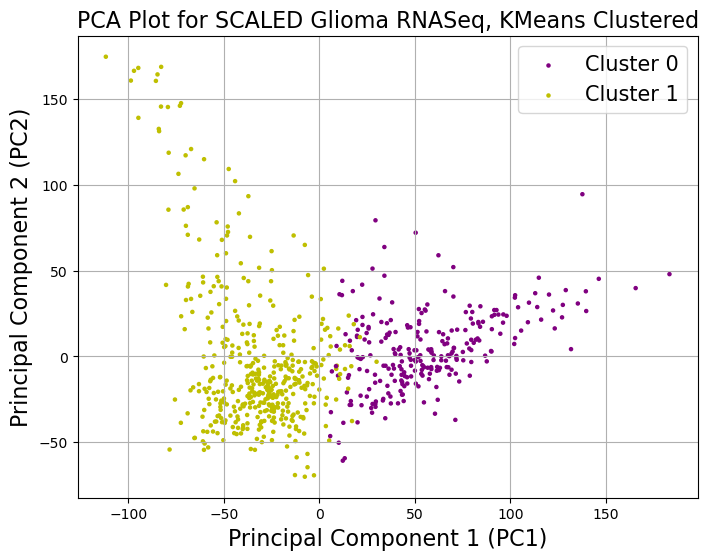

In [269]:
### KMEANS Scaled PCA ###

#Separate the PCA data into two clusters using Kmeans
cluster_labels = cluster.KMeans(n_clusters=2).fit(pca_df).labels_ 
color=[]

for c in cluster_labels:
    if c==0:
        color.append("purple")
    elif c==1:
        color.append("y")

#plot PC1 v PC2 with Kmeans cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], marker='o', s=5, c=color)
plt.scatter(pca_df['PC1'][600], pca_df['PC2'][600], marker='o', s = 5, c=color[600], label='Cluster 0')
plt.scatter(pca_df['PC1'][0], pca_df['PC2'][0], marker='o', s = 5, c=color[0], label='Cluster 1')

# Add labels and title
plt.xlabel('Principal Component 1 (PC1)', fontsize=16)
plt.ylabel('Principal Component 2 (PC2)', fontsize=16)
plt.title('PCA Plot for SCALED Glioma RNASeq, KMeans Clustered', fontsize=16)
plt.legend(fontsize=15)

plt.grid(True)
plt.show()

LGG:0.8220973782771536, GBM:0.9425287356321839


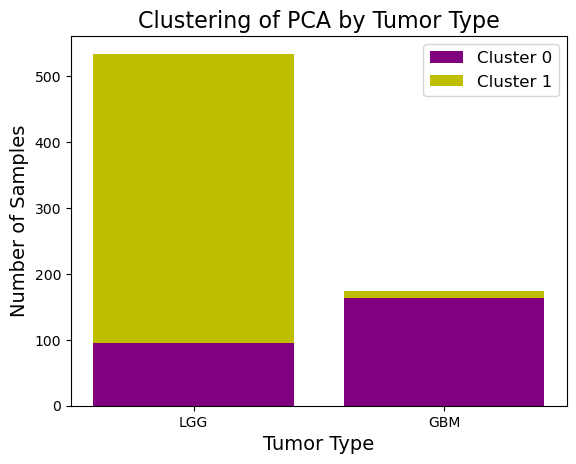

In [273]:
### STACKED BAR CHART FOR KMEANS CLUSTERING ###

#number of LGG samples classified into Cluster 1
lgg_1 = 0

#number of LGG samples classified into Cluster 0
lgg_0 = 0

#number of GBM samples classified into Cluster 1
gbm_1 = 0

#number of GBM samples classified into Cluster 0
gbm_0 = 0

#loop through each sample and count cluster classification for both tumor types
index=0
for i in tumor_ID:
    if i == "LGG":
        if cluster_labels[index] == 1:
            lgg_1 += 1
        elif cluster_labels[index] == 0:
            lgg_0 += 1
    elif i == "GBM":
        if cluster_labels[index] == 1:
            gbm_1 += 1
        elif cluster_labels[index] == 0:
            gbm_0 += 1
    index += 1


x=['LGG','GBM']
y1=[lgg_0,gbm_0]
y2=[lgg_1,gbm_1]

#Percentage of correctly classified tumors
print(f"LGG:{lgg_1/(lgg_0+lgg_1)}, GBM:{gbm_0/(gbm_1+gbm_0)}")

#Plot stacked bar chart with results
plt.bar(x, y1, color='purple', label='Cluster 0')
plt.bar(x, y2, bottom=y1, color='y', label='Cluster 1')
plt.xlabel('Tumor Type', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.title('Clustering of PCA by Tumor Type', fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [69]:
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

# Differential expression analysis 

display(df_GBM.head())

# concatenate both tumor datasets with tumor data 
combined_tumor_df = pd.concat([df_GBM, df_LGG])
combined_tumor_df_no_tumor = combined_tumor_df.drop(columns=['tumor'])
display(combined_tumor_df.head())
count_matrix = combined_tumor_df.drop(columns=['tumor'])
metadata = pd.DataFrame({'condition': combined_tumor_df['tumor']}, index=combined_tumor_df.index)
display(metadata)

# convert conuts to integers for differential expression analysis 
count_matrix = count_matrix.round().astype(int)
count_matrix = count_matrix.values
display(count_matrix)

# create DeseqDataSet 
dds = DeseqDataSet(counts=count_matrix, metadata=metadata)

# Initialize inference engine
inference = DefaultInference(n_cpus=8)

# Create DESeq2 dataset
dds = DeseqDataSet(
    counts=count_matrix, 
    metadata=metadata
)

dds.deseq2()
# Extract results
res = DeseqStats(dds, contrast=['condition', 'GBM', 'LGG'])
res.summary()

# Get the results as a DataFrame
DE_results_df = res.results_df
DE_results_df["gene_name"] = list(combined_tumor_df_no_tumor.columns)
display(DE_results_df)




gene_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932,tumor
TCGA-02-0047-01A-01R-1849-01,0.0,3.0732,6.7611,54.7036,886.321,0.0,232.951,0.0,0.0,0.0,...,356.495,1108.82,0.6146,1207.17,3867.97,1397.09,603.583,6.7611,0.0,GBM
TCGA-02-0055-01A-01R-1849-01,0.0,0.0,15.6973,31.3945,885.774,0.0,162.018,0.5606,0.0,0.0,...,280.308,607.708,5.0456,924.457,11481.4,606.027,718.15,12.3336,0.0,GBM
TCGA-02-2483-01A-01R-1849-01,0.0,2.9467,13.9398,60.3441,1234.83,0.0,135.092,0.0,0.0,0.0,...,406.121,866.28,44.3272,1208.65,5066.81,832.084,705.435,398.945,0.0,GBM
TCGA-02-2485-01A-01R-1849-01,0.0,15.9952,14.9571,91.8238,470.0,0.0,417.619,1.9048,0.0,0.0,...,274.286,1345.71,0.0,1070.0,5090.95,1139.52,700.476,15.7143,0.0,GBM
TCGA-02-2486-01A-01R-1849-01,0.0,5.561,4.8049,62.5366,546.341,0.0,276.219,0.0,0.0,0.0,...,198.171,652.439,0.0,689.634,7800.0,627.439,527.439,69.5122,0.0,GBM


gene_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932,tumor
TCGA-02-0047-01A-01R-1849-01,0.0,3.0732,6.7611,54.7036,886.321,0.0,232.951,0.0,0.0,0.0,...,356.495,1108.82,0.6146,1207.17,3867.97,1397.09,603.583,6.7611,0.0,GBM
TCGA-02-0055-01A-01R-1849-01,0.0,0.0,15.6973,31.3945,885.774,0.0,162.018,0.5606,0.0,0.0,...,280.308,607.708,5.0456,924.457,11481.4,606.027,718.15,12.3336,0.0,GBM
TCGA-02-2483-01A-01R-1849-01,0.0,2.9467,13.9398,60.3441,1234.83,0.0,135.092,0.0,0.0,0.0,...,406.121,866.28,44.3272,1208.65,5066.81,832.084,705.435,398.945,0.0,GBM
TCGA-02-2485-01A-01R-1849-01,0.0,15.9952,14.9571,91.8238,470.0,0.0,417.619,1.9048,0.0,0.0,...,274.286,1345.71,0.0,1070.0,5090.95,1139.52,700.476,15.7143,0.0,GBM
TCGA-02-2486-01A-01R-1849-01,0.0,5.561,4.8049,62.5366,546.341,0.0,276.219,0.0,0.0,0.0,...,198.171,652.439,0.0,689.634,7800.0,627.439,527.439,69.5122,0.0,GBM


,condition
TCGA-02-0047-01A-01R-1849-01,GBM
TCGA-02-0055-01A-01R-1849-01,GBM
TCGA-02-2483-01A-01R-1849-01,GBM
TCGA-02-2485-01A-01R-1849-01,GBM
TCGA-02-2486-01A-01R-1849-01,GBM
...,...
TCGA-WY-A85A-01A-21R-A36H-07,LGG
TCGA-WY-A85B-01A-11R-A36H-07,LGG
TCGA-WY-A85C-01A-11R-A36H-07,LGG
TCGA-WY-A85D-01A-11R-A36H-07,LGG


array([[   0,    3,    6, ...,  603,    6,    0],
       [   0,    0,   15, ...,  718,   12,    0],
       [   0,    2,   13, ...,  705,  398,    0],
       ...,
       [   0,   11,   18, ...,  910, 3013,    0],
       [   0,    5,    8, ...,  771, 1563,    0],
       [   0,    9,    7, ...,  626, 1209,    0]])

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.48 seconds.

Fitting dispersions...
... done in 2.22 seconds.

Fitting dispersion trend curve...
... done in 0.26 seconds.

Fitting MAP dispersions...
... done in 2.76 seconds.

Fitting LFCs...
... done in 1.28 seconds.

Calculating cook's distance...
... done in 1.78 seconds.

Replacing 1538 outlier genes.

Fitting dispersions...
... done in 0.21 seconds.

Fitting MAP dispersions...
... done in 0.22 seconds.

Fitting LFCs...
... done in 0.15 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition GBM vs LGG
          baseMean  log2FoldChange     lfcSE       stat         pvalue  \
0         0.002713       -0.018600  3.363512  -0.005530   9.955877e-01   
1         8.747384       -0.657944  0.112746  -5.835628   5.358844e-09   
2        14.401774       -0.837110  0.081040 -10.329643   5.175285e-25   
3       127.749062       -1.387450  0.041574 -33.373128  3.365165e-244   
4       653.475714       -0.058501  0.038351  -1.525406   1.271577e-01   
...            ...             ...       ...        ...            ...   
20526  3900.964471        1.349784  0.068244  19.778762   4.536935e-87   
20527  1538.247579       -0.687236  0.038679 -17.767606   1.259518e-70   
20528   616.438872        0.127568  0.042910   2.972951   2.949515e-03   
20529   520.523009       -3.691808  0.192538 -19.174409   6.055269e-82   
20530     0.004314       -0.024004  3.363500  -0.007136   9.943060e-01   

                padj  
0       9.998997e-01  
1     

... done in 0.82 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
0,0.002713,-0.018600,3.363512,-0.005530,9.955877e-01,9.998997e-01,?|100130426
1,8.747384,-0.657944,0.112746,-5.835628,5.358844e-09,1.040379e-08,?|100133144
2,14.401774,-0.837110,0.081040,-10.329643,5.175285e-25,1.907275e-24,?|100134869
3,127.749062,-1.387450,0.041574,-33.373128,3.365165e-244,3.181363e-241,?|10357
4,653.475714,-0.058501,0.038351,-1.525406,1.271577e-01,1.573953e-01,?|10431
...,...,...,...,...,...,...,...
20526,3900.964471,1.349784,0.068244,19.778762,4.536935e-87,1.602701e-85,ZYX|7791
20527,1538.247579,-0.687236,0.038679,-17.767606,1.259518e-70,2.510563e-69,ZZEF1|23140
20528,616.438872,0.127568,0.042910,2.972951,2.949515e-03,4.189206e-03,ZZZ3|26009
20529,520.523009,-3.691808,0.192538,-19.174409,6.055269e-82,1.754967e-80,psiTPTE22|387590


/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


0         9.955877e-01
1         5.358844e-09
2         5.175285e-25
3        3.365165e-244
4         1.271577e-01
             ...      
20526     4.536935e-87
20527     1.259518e-70
20528     2.949515e-03
20529     6.055269e-82
20530     9.943060e-01
Name: pvalue, Length: 20531, dtype: float64
9.689783288516556e-11


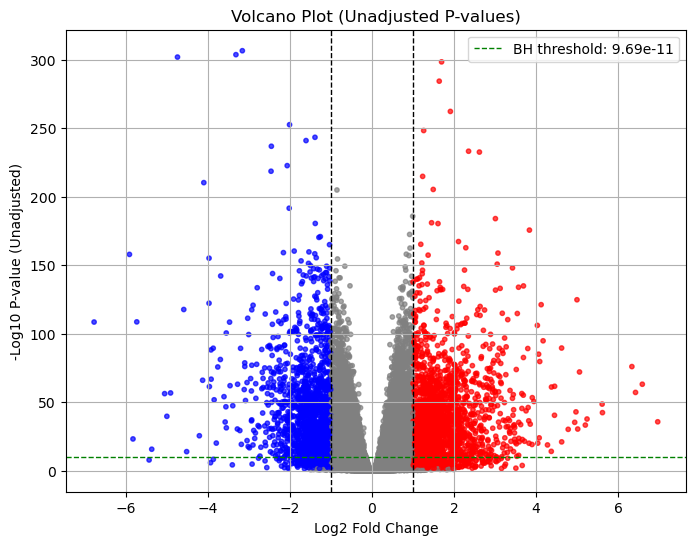

In [83]:
# plotting volcano plot
DE_results_df['-log10(pvalue)'] = -np.log10(DE_results_df['pvalue'])
log_fold_change_thresh = 1
pval_thresh = 0.05
DE_results_df['color'] = 'gray'

print(DE_results_df['pvalue'])

DE_results_df.loc[(DE_results_df['log2FoldChange'] >= log_fold_change_thresh) & (DE_results_df['pvalue'] < pval_thresh),'color'] = 'red'   # Upregulated
DE_results_df.loc[(DE_results_df['log2FoldChange'] <= -log_fold_change_thresh) & (DE_results_df['pvalue'] < pval_thresh),'color'] = 'blue'  # Downregulated


# # Benjamini Hochberg
# _, BH_pvals, _, _ = multipletests(DE_results_df['pvalue'], method="fdr_bh")

# DE_results_df['BH_pvalue'] = BH_pvals
# significant_BH_pvals = BH_pvals[BH_pvals < 0.05]
# BH_pval_threshold = min(significant_BH_pvals, default=0.05)  # Set default if no significant values
# #BH_threshold_log10 = -np.log10(BH_pval_threshold)  # Convert to -log10 scale for plotting

all_pvals = DE_results_df['padj'].tolist()
all_pvals.sort()
n_tests = len(all_pvals)
alpha_cutoff = np.arange(0, n_tests)*((0.08 - 0.08/n_tests))/n_tests + 0.08/n_tests
n_pvals_below_cutoff = len([x for x in alpha_cutoff - all_pvals if x >= 0])
BH_pval_threshold = all_pvals[n_pvals_below_cutoff-1]
print(BH_pval_threshold)


plt.figure(figsize=(8, 6))
plt.scatter(DE_results_df['log2FoldChange'], DE_results_df['-log10(pvalue)'], c=DE_results_df['color'], alpha=0.7, s=10)

plt.axvline(x=log_fold_change_thresh, color='black', linestyle='--', linewidth=1) 
plt.axvline(x=-log_fold_change_thresh, color='black', linestyle='--', linewidth=1) 
plt.axhline(y=-np.log10(BH_pval_threshold), color='green', linestyle='--', linewidth=1, label=f'BH threshold: {BH_pval_threshold:.2e}')

# Labels and title
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-value (Unadjusted)")
plt.title("Volcano Plot (Unadjusted P-values)")

# Grid and show plot
plt.grid(True)
plt.legend()
plt.show()